In [18]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("Momentum 52-week strategy using Yahoo Finance data")

def momentum_52week_strategy(tickers, start_date, end_date):

    # --- Portfolio Settings ---
    starting_cash = 100
    position_size = 10.0      # $10 notional per new trade
    hold_period_days = 15     # 15 trading days
    cash = starting_cash
    portfolio_value_daily = []

    # Track open positions with exit info
    # each element: dict(ticker, buy_date, buy_price, shares)
    open_positions = []

    # Master trade log
    all_trades = []

    # --- Download data from Yahoo Finance ---
    print(" Downloading price data from Yahoo Finance...")
    data = yf.download(tickers, start=start_date, end=end_date, progress=False)

    close = data["Close"]
    high = data["High"]
    all_dates = close.index

    # Pre-compute 52-week (252 trading days) rolling high *excluding* today
    # Use shift(1) so that today's 52w_high is computed from prior days only. [web:2][web:5]
    high_52w_prior = high.rolling(252, min_periods=50).max().shift(1)

    # --- DAILY BACKTEST LOOP ---
    for i, current_date in enumerate(all_dates):

        # --- STEP 1: Check for positions to exit (15 trading-day hold) ---
        new_open_positions = []
        for pos in open_positions:
            buy_idx = all_dates.get_loc(pos["buy_date"])
            if i >= buy_idx + hold_period_days:
                # Exit at today's close
                sell_price = close.loc[current_date, pos["ticker"]]
                exit_amount = pos["shares"] * sell_price
                ret_pct = (sell_price - pos["buy_price"]) / pos["buy_price"] * 100

                all_trades.append({
                    "ticker": pos["ticker"],
                    "buy_date": pos["buy_date"].strftime('%Y-%m-%d'),
                    "buy_price": round(pos["buy_price"], 4),
                    "buy_amount": round(position_size, 2),
                    "exit_date": current_date.strftime('%Y-%m-%d'),
                    "exit_price": round(sell_price, 4),
                    "exit_amount": round(exit_amount, 2),
                    "return_pct": round(ret_pct, 2)
                })

                cash += exit_amount
            else:
                new_open_positions.append(pos)
        open_positions = new_open_positions

        # --- STEP 2: Process BUY signals ---
        for ticker in tickers:
            # Skip if this ticker is already held
            if ticker in [pos["ticker"] for pos in open_positions]:
                continue

            # Need both today's data and prior 52-week high
            if ticker not in high.columns or ticker not in close.columns:
                continue
            if pd.isna(high.loc[current_date, ticker]):
                continue

            today_high = high.loc[current_date, ticker]
            today_close = close.loc[current_date, ticker]
            prior_52w_high = high_52w_prior.loc[current_date, ticker]

            # Require at least some lookback history
            if pd.isna(prior_52w_high):
                continue

            # "New 1-year high" = today's high is strictly greater than any high in prior 252 trading days. [web:1][web:10]
            if (today_high > prior_52w_high) and (cash >= position_size):
                # Determine number of shares for $10 notional at close
                shares = position_size / today_close

                open_positions.append({
                    "ticker": ticker,
                    "buy_date": current_date,
                    "buy_price": today_close,
                    "shares": shares
                })
                cash -= position_size

        # --- STEP 3: Track daily portfolio value (mark-to-market) ---
        # Mark each open position to today's close. [web:9]
        holdings_value = 0.0
        for pos in open_positions:
            price_today = close.loc[current_date, pos["ticker"]]
            holdings_value += pos["shares"] * price_today

        total_value = cash + holdings_value
        portfolio_value_daily.append({
            "date": current_date,
            "cash": round(cash, 2),
            "invested": round(holdings_value, 2),
            "total_value": round(total_value, 2),
            "holdings": [pos["ticker"] for pos in open_positions]
        })

    # --- Convert portfolio value to DataFrame ---
    pv = pd.DataFrame(portfolio_value_daily)

    # Filter to first day of each month for first 30 months
    pv_first_of_month = pv.copy()
    pv_first_of_month['month'] = pv_first_of_month['date'].dt.to_period('M')
    pv_first_of_month = pv_first_of_month.drop_duplicates(subset='month', keep='first')
    pv_first_of_month = pv_first_of_month.head(30)

    # Extract holdings for each of these dates
    holdings_table = pv_first_of_month[['date', 'holdings']].copy()
    holdings_table.rename(columns={'holdings': 'tickers_in_portfolio'}, inplace=True)

    # Convert trades to DataFrame and show first 30 trades
    trades_df = pd.DataFrame(all_trades)
    trades_first30 = trades_df.sort_values("buy_date").head(30)

    # --- OUTPUT ---
    print(" Portfolio Value (first day of each month, first 30 months):")
    print(pv_first_of_month[['date', 'cash', 'invested', 'total_value']].to_string(index=False))

    print(" Holdings at start of each month (first 30 months):")
    print(holdings_table.to_string(index=False))

    print(" First 30 trades:")
    if trades_first30.empty:
        print("No trades executed.")
    else:
        print(trades_first30.to_string(index=False,
            columns=["ticker", "buy_date", "buy_price", "buy_amount",
                     "exit_date", "exit_price", "exit_amount", "return_pct"]))

    print("Final Cash:", round(cash, 2))
    print("Final Invested (MTM):", round(holdings_value, 2))
    print("Total Value:", round(cash + holdings_value, 2))

    return trades_df, pv, open_positions, holdings_table

# --- RUN MODEL ---

tickers = [
"AAPL",
"AMGN",
"AXP",
"BA",
"CAT",
"CRM",
"CSCO",
"CVX",
"DIS",
"DOW",
"GS",
"HD",
"HON",
"IBM",
"INTC",
"JNJ",
"JPM",
"KO",
"MCD",
"MMM",
"MRK",
"MSFT",
"NKE",
"PG",
"TRV",
"UNH",
"V",
"VZ",
"WMT"
]

trades, pv, open_positions, holdings_table = momentum_52week_strategy(
    tickers,
    "2023-01-01",
    "2025-11-30"
)


Momentum 52-week strategy using Yahoo Finance data
 Portfolio Value (first day of each month, first 30 months):
      date   cash  invested  total_value
2023-01-03 100.00      0.00       100.00
2023-02-01 100.00      0.00       100.00
2023-03-01 100.00      0.00       100.00
2023-04-03  30.00     72.38       102.38
2023-05-01   2.38     99.96       102.34
2023-06-01  73.22     30.46       103.68
2023-07-03  13.87     90.24       104.12
2023-08-01  24.65     80.50       105.15
2023-09-01  53.86     50.63       104.49
2023-10-02  82.22     19.21       101.43
2023-11-01 101.49      0.00       101.49
2023-12-01  40.92     62.23       103.15
2024-01-02   3.60    100.80       104.41
2024-02-01  17.38     93.39       110.77
2024-03-01   2.39    111.65       114.04
2024-04-01   5.59    110.32       115.91
2024-05-01  61.74     50.43       112.17
2024-06-03  63.95     49.87       113.82
2024-07-01  54.95     60.06       115.01
2024-08-01  36.05     79.58       115.63
2024-09-03  13.92    102.04

In [19]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("Momentum 52-week strategy using Yahoo Finance data")

def momentum_52week_strategy(tickers, start_date, end_date):

    # --- Portfolio Settings ---
    starting_cash = 100        # Start with $100
    position_size = 6.0        # $6 notional per new trade
    hold_period_days = 15      # 15 trading days
    cash = starting_cash
    portfolio_value_daily = []

    # Track open positions with exit info
    # each element: dict(ticker, buy_date, buy_price, shares)
    open_positions = []

    # Master trade log
    all_trades = []

    # --- Download data from Yahoo Finance ---
    print(" Downloading price data from Yahoo Finance...")
    data = yf.download(tickers, start=start_date, end=end_date, progress=False)

    close = data["Close"]
    high = data["High"]
    all_dates = close.index

    # Pre-compute 52-week (252 trading days) rolling high *excluding* today
    # Use shift(1) so that today's 52w_high is computed from prior days only.
    high_52w_prior = high.rolling(252, min_periods=50).max().shift(1)

    # --- DAILY BACKTEST LOOP ---
    for i, current_date in enumerate(all_dates):

        # --- STEP 1: Check for positions to exit (15 trading-day hold) ---
        new_open_positions = []
        for pos in open_positions:
            buy_idx = all_dates.get_loc(pos["buy_date"])
            if i >= buy_idx + hold_period_days:
                # Exit at today's close
                sell_price = close.loc[current_date, pos["ticker"]]
                exit_amount = pos["shares"] * sell_price
                ret_pct = (sell_price - pos["buy_price"]) / pos["buy_price"] * 100

                all_trades.append({
                    "ticker": pos["ticker"],
                    "buy_date": pos["buy_date"].strftime('%Y-%m-%d'),
                    "buy_price": round(pos["buy_price"], 4),
                    "buy_amount": round(position_size, 2),
                    "exit_date": current_date.strftime('%Y-%m-%d'),
                    "exit_price": round(sell_price, 4),
                    "exit_amount": round(exit_amount, 2),
                    "return_pct": round(ret_pct, 2)
                })

                cash += exit_amount
            else:
                new_open_positions.append(pos)
        open_positions = new_open_positions

        # --- STEP 2: Process BUY signals ---
        for ticker in tickers:
            # Skip if this ticker is already held
            if ticker in [pos["ticker"] for pos in open_positions]:
                continue

            # Need both today's data and prior 52-week high
            if ticker not in high.columns or ticker not in close.columns:
                continue
            if pd.isna(high.loc[current_date, ticker]):
                continue

            today_high = high.loc[current_date, ticker]
            today_close = close.loc[current_date, ticker]
            prior_52w_high = high_52w_prior.loc[current_date, ticker]

            # Require at least some lookback history
            if pd.isna(prior_52w_high):
                continue

            # "New 1-year high" = today's high is strictly greater than any high in prior 252 trading days.
            if (today_high > prior_52w_high) and (cash >= position_size):
                # Determine number of shares for $6 notional at close
                shares = position_size / today_close

                open_positions.append({
                    "ticker": ticker,
                    "buy_date": current_date,
                    "buy_price": today_close,
                    "shares": shares
                })
                cash -= position_size

        # --- STEP 3: Track daily portfolio value (mark-to-market) ---
        holdings_value = 0.0
        for pos in open_positions:
            price_today = close.loc[current_date, pos["ticker"]]
            holdings_value += pos["shares"] * price_today

        total_value = cash + holdings_value
        portfolio_value_daily.append({
            "date": current_date,
            "cash": round(cash, 2),
            "invested": round(holdings_value, 2),
            "total_value": round(total_value, 2),
            "holdings": [pos["ticker"] for pos in open_positions]
        })

    # --- Convert portfolio value to DataFrame ---
    pv = pd.DataFrame(portfolio_value_daily)

    # Filter to first day of each month for first 30 months
    pv_first_of_month = pv.copy()
    pv_first_of_month['month'] = pv_first_of_month['date'].dt.to_period('M')
    pv_first_of_month = pv_first_of_month.drop_duplicates(subset='month', keep='first')
    pv_first_of_month = pv_first_of_month.head(30)

    # Extract holdings for each of these dates
    holdings_table = pv_first_of_month[['date', 'holdings']].copy()
    holdings_table.rename(columns={'holdings': 'tickers_in_portfolio'}, inplace=True)

    # Count how many of the 29 stocks are held at each time
    holdings_table['num_stocks_held'] = holdings_table['tickers_in_portfolio'].apply(len)

    # Convert trades to DataFrame and show first 30 trades
    trades_df = pd.DataFrame(all_trades)
    trades_first30 = trades_df.sort_values("buy_date").head(30)

    # --- OUTPUT ---
    print(" Holdings at start of each month (first 30 months):")
    print(holdings_table.to_string(index=False))

    print(" Portfolio Value (first day of each month, first 30 months):")
    print(pv_first_of_month[['date', 'cash', 'invested', 'total_value']].to_string(index=False))

    print(" First 30 trades:")
    if trades_first30.empty:
        print("No trades executed.")
    else:
        print(trades_first30.to_string(index=False,
            columns=["ticker", "buy_date", "buy_price", "buy_amount",
                     "exit_date", "exit_price", "exit_amount", "return_pct"]))

    print("Final Cash:", round(cash, 2))
    print("Final Invested (MTM):", round(holdings_value, 2))
    print("Total Value:", round(cash + holdings_value, 2))

    return trades_df, pv, open_positions, holdings_table

# --- RUN MODEL ---

tickers = [
    "AAPL",
    "AMGN",
    "AXP",
    "BA",
    "CAT",
    "CRM",
    "CSCO",
    "CVX",
    "DIS",
    "DOW",
    "GS",
    "HD",
    "HON",
    "IBM",
    "INTC",
    "JNJ",
    "JPM",
    "KO",
    "MCD",
    "MMM",
    "MRK",
    "MSFT",
    "NKE",
    "PG",
    "TRV",
    "UNH",
    "V",
    "VZ",
    "WMT"
]

trades, pv, open_positions, holdings_table = momentum_52week_strategy(
    tickers,
    "2023-01-01",
    "2025-06-30"
)


Momentum 52-week strategy using Yahoo Finance data
 Holdings at start of each month (first 30 months):
      date                                             tickers_in_portfolio  num_stocks_held
2023-01-03                                                               []                0
2023-02-01                                                               []                0
2023-03-01                                                               []                0
2023-04-03                          [MSFT, INTC, AAPL, MCD, CRM, CSCO, WMT]                7
2023-05-01                 [UNH, MRK, V, KO, AAPL, MCD, PG, WMT, MSFT, JPM]               10
2023-06-01                                                [AAPL, MSFT, CRM]                3
2023-07-03                   [BA, INTC, WMT, JPM, MSFT, CSCO, AAPL, MCD, V]                9
2023-08-01                   [CRM, MSFT, AAPL, CAT, WMT, BA, IBM, PG, INTC]                9
2023-09-01                                          [WMT, HD

In [23]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("Momentum 52-week strategy using Yahoo Finance data")

def momentum_52week_strategy(tickers, start_date, end_date):
    starting_cash = 100
    position_size = 20.0       # $20 notional per new trade
    hold_period_days = 15      # 15 trading days
    transaction_cost_pct = 0.0003  # 3 basis points
    cash = starting_cash
    portfolio_value_daily = []
    open_positions = []
    daily_blocked_tickers = []
    all_trades = []

    print(" Downloading price data from Yahoo Finance...")
    data = yf.download(tickers, start=start_date, end=end_date, progress=False)
    close = data["Close"]
    high = data["High"]
    all_dates = close.index

    high_52w_prior = high.rolling(252, min_periods=50).max().shift(1)
    total_commission_paid = 0.0

    for i, current_date in enumerate(all_dates):
        new_open_positions = []
        for pos in open_positions:
            buy_idx = all_dates.get_loc(pos["buy_date"])
            if i >= buy_idx + hold_period_days:
                sell_price = close.loc[current_date, pos["ticker"]]
                exit_amount = pos["shares"] * sell_price
                ret_pct = (sell_price - pos["buy_price"]) / pos["buy_price"] * 100

                # Commission for sell
                sell_commission = exit_amount * transaction_cost_pct
                total_commission_paid += sell_commission
                cash += exit_amount - sell_commission

                all_trades.append({
                    "ticker": pos["ticker"],
                    "buy_date": pos["buy_date"].strftime('%Y-%m-%d'),
                    "buy_price": round(pos["buy_price"], 4),
                    "buy_amount": round(position_size, 2),
                    "exit_date": current_date.strftime('%Y-%m-%d'),
                    "exit_price": round(sell_price, 4),
                    "exit_amount": round(exit_amount, 2),
                    "return_pct": round(ret_pct, 2),
                    "commission": round(sell_commission + pos["buy_commission"], 6)
                })
            else:
                new_open_positions.append(pos)
        open_positions = new_open_positions

        unable_to_fund = []

        for ticker in tickers:
            if ticker in [pos["ticker"] for pos in open_positions]:
                continue
            if ticker not in high.columns or ticker not in close.columns:
                continue
            if pd.isna(high.loc[current_date, ticker]):
                continue

            today_high = high.loc[current_date, ticker]
            today_close = close.loc[current_date, ticker]
            prior_52w_high = high_52w_prior.loc[current_date, ticker]
            if pd.isna(prior_52w_high):
                continue

            if today_high > prior_52w_high:
                if cash >= position_size:
                    shares = position_size / today_close
                    buy_commission = position_size * transaction_cost_pct
                    total_commission_paid += buy_commission
                    cash -= (position_size + buy_commission)
                    open_positions.append({
                        "ticker": ticker,
                        "buy_date": current_date,
                        "buy_price": today_close,
                        "shares": shares,
                        "buy_commission": buy_commission
                    })
                else:
                    unable_to_fund.append(ticker)

        daily_blocked_tickers.append({
            "date": current_date,
            "tickers unable to fund": unable_to_fund
        })

        holdings_value = sum(pos["shares"] * close.loc[current_date, pos["ticker"]] for pos in open_positions)
        total_value = cash + holdings_value
        total_value_no_commission = total_value + total_commission_paid

        portfolio_value_daily.append({
            "date": current_date,
            "cash": round(cash, 2),
            "invested": round(holdings_value, 2),
            "total_value": round(total_value, 2),
            "total_value_no_commission": round(total_value_no_commission, 2),
            "holdings": [pos["ticker"] for pos in open_positions]
        })

    pv = pd.DataFrame(portfolio_value_daily)
    pv_first_of_month = pv.copy()
    pv_first_of_month['month'] = pv_first_of_month['date'].dt.to_period('M')
    pv_first_of_month = pv_first_of_month.drop_duplicates(subset='month', keep='first')

    holdings_table = pv_first_of_month[['date', 'holdings']].copy()
    holdings_table.rename(columns={'holdings': 'tickers_in_portfolio'}, inplace=True)
    holdings_table['num_stocks_held'] = holdings_table['tickers_in_portfolio'].apply(len)

    blocked_df = pd.DataFrame(daily_blocked_tickers)
    blocked_df['month'] = blocked_df['date'].dt.to_period('M')
    blocked_first_of_month = blocked_df.drop_duplicates(subset='month', keep='first')
    monthly_info = pd.merge(
        holdings_table,
        blocked_first_of_month[['date', 'tickers unable to fund']],
        on='date',
        how='left'
    )
    monthly_info['tickers unable to fund'] = monthly_info['tickers unable to fund'].apply(lambda x: x if isinstance(x, list) else [])

    dji_data = yf.download("^DJI", start=start_date, end=end_date, progress=False)
    dji_close = dji_data["Close"]
    dji_on_pv_dates = dji_close.reindex(pv_first_of_month['date'], method='ffill')
    dji_start = dji_on_pv_dates.iloc[0]
    dji_scaled = 100 * (dji_on_pv_dates / dji_start)
    pv_first_of_month = pv_first_of_month.copy()
    pv_first_of_month['dji_value_from_100'] = dji_scaled.values

    pv_first_of_month['portfolio_max_to_date'] = pv_first_of_month['total_value'].cummax()
    pv_first_of_month['dji_max_to_date'] = pv_first_of_month['dji_value_from_100'].cummax()

    pv_first_of_month['portfolio_drawdown_pct'] = (
        100 * (pv_first_of_month['total_value'] - pv_first_of_month['portfolio_max_to_date']) /
        pv_first_of_month['portfolio_max_to_date']
    ).round(2)

    pv_first_of_month['dji_drawdown_pct'] = (
        100 * (pv_first_of_month['dji_value_from_100'] - pv_first_of_month['dji_max_to_date']) /
        pv_first_of_month['dji_max_to_date']
    ).round(2)

    trades_df = pd.DataFrame(all_trades)
    trades_first10 = trades_df.sort_values("buy_date").head(10)
    trades_last10 = trades_df.sort_values("buy_date").tail(10)

    print(" Holdings and tickers unable to fund (first trading day of each month):")
    print(monthly_info.to_string(index=False))

    print("\n Portfolio Value vs ^DJI (first trading day of each month):")
    print(pv_first_of_month[['date', 'cash', 'invested', 'total_value', 'total_value_no_commission',
                             'dji_value_from_100',
                             'portfolio_drawdown_pct',
                             'dji_drawdown_pct']].to_string(index=False))

    print("End period total value of portfolio:", round(cash + holdings_value, 2))
    print("Total commission paid over period:", round(total_commission_paid, 2))

    # ---- PRINT FIRST & LAST TRADES ----
    print("\n First 10 trades:")
    if trades_first10.empty:
        print("No trades executed.")
    else:
        print(trades_first10.to_string(index=False,
            columns=["ticker", "buy_date", "buy_price", "buy_amount",
                     "exit_date", "exit_price", "exit_amount", "return_pct", "commission"]))

    print("\n Last 10 trades:")
    if trades_last10.empty:
        print("No trades executed.")
    else:
        print(trades_last10.to_string(index=False,
            columns=["ticker", "buy_date", "buy_price", "buy_amount",
                     "exit_date", "exit_price", "exit_amount", "return_pct", "commission"]))

    # ---- LARGEST DRAWDOWNS TABLE ----
    dji_drawdowns = pv_first_of_month[['month', 'dji_drawdown_pct']].sort_values(by='dji_drawdown_pct').head(3)
    portfolio_drawdowns = pv_first_of_month[['month', 'portfolio_drawdown_pct']].sort_values(by='portfolio_drawdown_pct').head(3)
    portfolio_max_dd = pv_first_of_month['portfolio_drawdown_pct'].min()

    print("\n Largest Drawdowns Summary:")
    print("\nTop 3 largest drawdowns for ^DJI:")
    print(dji_drawdowns.to_string(index=False))

    print("\nPortfolio largest drawdown over entire period:", portfolio_max_dd)
    print("\nTop 3 months with largest portfolio drawdowns:")
    print(portfolio_drawdowns.to_string(index=False))

    return trades_df, pv, open_positions, monthly_info, pv_first_of_month


# --- RUN MODEL ---
tickers = [
    "AAPL","AMGN","AXP","BA","CAT","CRM","CSCO","CVX","DIS","DOW","GS","HD","HON","IBM",
    "INTC","JNJ","JPM","KO","MCD","MMM","MRK","MSFT","NKE","PG","TRV","UNH","V","VZ","WMT"
]

trades, pv, open_positions, monthly_info, pv_first_of_month = momentum_52week_strategy(
    tickers,
    "2019-01-01",
    "2025-06-30"
)


Momentum 52-week strategy using Yahoo Finance data
 Holdings and tickers unable to fund (first trading day of each month):
      date                   tickers_in_portfolio  num_stocks_held                         tickers unable to fund
2019-01-02                                     []                0                                             []
2019-02-01                                     []                0                                             []
2019-03-01                                     []                0                                             []
2019-04-01                [AAPL, AXP, CSCO, INTC]                4 [HD, HON, IBM, JNJ, MCD, MMM, MRK, PG, TRV, V]
2019-05-01              [CRM, DIS, HON, JPM, JNJ]                5                            [AAPL, AXP, TRV, V]
2019-06-03                    [MCD, TRV, AXP, KO]                4                                             []
2019-07-01                  [CSCO, MSFT, JNJ, PG]                4             

In [24]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("Momentum strategy with 52-week screen")

def momentum_52week_strategy(tickers, start_date, end_date):
    starting_cash = 100
    position_size = 20.0       # $20 notional per new trade
    hold_period_days = 15      # 15 trading days
    transaction_cost_pct = 0.0003  # 3 basis points
    cash = starting_cash
    portfolio_value_daily = []
    open_positions = []
    daily_blocked_tickers = []
    all_trades = []

    print(" Price data from Yahoo Finance...")
    data = yf.download(tickers, start=start_date, end=end_date, progress=False)
    close = data["Close"]
    high = data["High"]
    all_dates = close.index

    high_52w_prior = high.rolling(252, min_periods=50).max().shift(1)
    total_commission_paid = 0.0

    for i, current_date in enumerate(all_dates):
        new_open_positions = []
        for pos in open_positions:
            buy_idx = all_dates.get_loc(pos["buy_date"])
            if i >= buy_idx + hold_period_days:
                sell_price = close.loc[current_date, pos["ticker"]]
                exit_amount = pos["shares"] * sell_price
                ret_pct = (sell_price - pos["buy_price"]) / pos["buy_price"] * 100

                # Commission for sell
                sell_commission = exit_amount * transaction_cost_pct
                total_commission_paid += sell_commission
                cash += exit_amount - sell_commission

                all_trades.append({
                    "ticker": pos["ticker"],
                    "buy_date": pos["buy_date"].strftime('%Y-%m-%d'),
                    "buy_price": round(pos["buy_price"], 4),
                    "buy_amount": round(position_size, 2),
                    "exit_date": current_date.strftime('%Y-%m-%d'),
                    "exit_price": round(sell_price, 4),
                    "exit_amount": round(exit_amount, 2),
                    "return_pct": round(ret_pct, 2),
                    "commission": round(sell_commission + pos["buy_commission"], 6)
                })
            else:
                new_open_positions.append(pos)
        open_positions = new_open_positions

        unable_to_fund = []

        for ticker in tickers:
            if ticker in [pos["ticker"] for pos in open_positions]:
                continue
            if ticker not in high.columns or ticker not in close.columns:
                continue
            if pd.isna(high.loc[current_date, ticker]):
                continue

            today_high = high.loc[current_date, ticker]
            today_close = close.loc[current_date, ticker]
            prior_52w_high = high_52w_prior.loc[current_date, ticker]
            if pd.isna(prior_52w_high):
                continue

            if today_high > prior_52w_high:
                if cash >= position_size:
                    shares = position_size / today_close
                    buy_commission = position_size * transaction_cost_pct
                    total_commission_paid += buy_commission
                    cash -= (position_size + buy_commission)
                    open_positions.append({
                        "ticker": ticker,
                        "buy_date": current_date,
                        "buy_price": today_close,
                        "shares": shares,
                        "buy_commission": buy_commission
                    })
                else:
                    unable_to_fund.append(ticker)

        daily_blocked_tickers.append({
            "date": current_date,
            "tickers unable to fund": unable_to_fund
        })

        holdings_value = sum(pos["shares"] * close.loc[current_date, pos["ticker"]] for pos in open_positions)
        total_value = cash + holdings_value
        total_value_no_commission = total_value + total_commission_paid

        portfolio_value_daily.append({
            "date": current_date,
            "cash": round(cash, 2),
            "invested": round(holdings_value, 2),
            "total_value": round(total_value, 2),
            "total_value_no_commission": round(total_value_no_commission, 2),
            "holdings": [pos["ticker"] for pos in open_positions]
        })

    pv = pd.DataFrame(portfolio_value_daily)
    pv_first_of_month = pv.copy()
    pv_first_of_month['month'] = pv_first_of_month['date'].dt.to_period('M')
    pv_first_of_month = pv_first_of_month.drop_duplicates(subset='month', keep='first')

    holdings_table = pv_first_of_month[['date', 'holdings']].copy()
    holdings_table.rename(columns={'holdings': 'tickers_in_portfolio'}, inplace=True)
    holdings_table['num_stocks_held'] = holdings_table['tickers_in_portfolio'].apply(len)

    blocked_df = pd.DataFrame(daily_blocked_tickers)
    blocked_df['month'] = blocked_df['date'].dt.to_period('M')
    blocked_first_of_month = blocked_df.drop_duplicates(subset='month', keep='first')
    monthly_info = pd.merge(
        holdings_table,
        blocked_first_of_month[['date', 'tickers unable to fund']],
        on='date',
        how='left'
    )
    monthly_info['tickers unable to fund'] = monthly_info['tickers unable to fund'].apply(lambda x: x if isinstance(x, list) else [])

    dji_data = yf.download("^DJI", start=start_date, end=end_date, progress=False)
    dji_close = dji_data["Close"]
    dji_on_pv_dates = dji_close.reindex(pv_first_of_month['date'], method='ffill')
    dji_start = dji_on_pv_dates.iloc[0]
    dji_scaled = 100 * (dji_on_pv_dates / dji_start)
    pv_first_of_month = pv_first_of_month.copy()
    pv_first_of_month['dji_value_from_100'] = dji_scaled.values

    pv_first_of_month['portfolio_max_to_date'] = pv_first_of_month['total_value'].cummax()
    pv_first_of_month['dji_max_to_date'] = pv_first_of_month['dji_value_from_100'].cummax()

    pv_first_of_month['portfolio_drawdown_pct'] = (
        100 * (pv_first_of_month['total_value'] - pv_first_of_month['portfolio_max_to_date']) /
        pv_first_of_month['portfolio_max_to_date']
    ).round(2)

    pv_first_of_month['dji_drawdown_pct'] = (
        100 * (pv_first_of_month['dji_value_from_100'] - pv_first_of_month['dji_max_to_date']) /
        pv_first_of_month['dji_max_to_date']
    ).round(2)

    trades_df = pd.DataFrame(all_trades)
    trades_first10 = trades_df.sort_values("buy_date").head(10)
    trades_last10 = trades_df.sort_values("buy_date").tail(10)

    # ---- LARGEST DRAWDOWNS TABLE ----
    dji_drawdowns = pv_first_of_month[['month', 'dji_drawdown_pct']].sort_values(by='dji_drawdown_pct').head(3)
    portfolio_drawdowns = pv_first_of_month[['month', 'portfolio_drawdown_pct']].sort_values(by='portfolio_drawdown_pct').head(3)
    portfolio_max_dd = pv_first_of_month['portfolio_drawdown_pct'].min()

    print("\nPortfolio Value vs Dow Jones Index (DJI) on first trading day of each month:")
    print(pv_first_of_month[['date', 'cash', 'invested', 'total_value', 'total_value_no_commission',
                             'dji_value_from_100',
                             'portfolio_drawdown_pct',
                             'dji_drawdown_pct']].to_string(index=False))

    print("\nTotal commission paid over period:", round(total_commission_paid, 2))

    print("\nComparision of Dow Jones 30 and portfolio largest drawdowns:")
    print("\nTop 3 largest drawdowns for Dow Jones 30:")
    print(dji_drawdowns.to_string(index=False))

    print("\nPortfolio largest drawdown over entire period:", portfolio_max_dd)
    print("\nTop 3 months with largest portfolio drawdowns:")
    print(portfolio_drawdowns.to_string(index=False))

    # ---- PRINT FIRST & LAST TRADES ----
    print("\nFirst 10 trades:")
    if trades_first10.empty:
        print("No trades executed.")
    else:
        print(trades_first10.to_string(index=False,
            columns=["ticker", "buy_date", "buy_price", "buy_amount",
                     "exit_date", "exit_price", "exit_amount", "return_pct", "commission"]))

    print("\nLast 10 trades:")
    if trades_last10.empty:
        print("No trades executed.")
    else:
        print(trades_last10.to_string(index=False,
            columns=["ticker", "buy_date", "buy_price", "buy_amount",
                     "exit_date", "exit_price", "exit_amount", "return_pct", "commission"]))

    # ---- HOLDINGS AND UNABLE TO FUND LAST ----
    print("\nPortfolio holdings and tickers unable to fund (date is first trading day of each month):")
    print(monthly_info.to_string(index=False))

    return trades_df, pv, open_positions, monthly_info, pv_first_of_month


# --- RUN MODEL ---
tickers = [
    "AAPL","AMGN","AXP","BA","CAT","CRM","CSCO","CVX","DIS","DOW","GS","HD","HON","IBM",
"INTC","JNJ","JPM","KO","MCD","MMM","MRK","MSFT","NKE","PFE","PG","RTX","TRV","UNH","V","VZ","WMT"
]

trades, pv, open_positions, monthly_info, pv_first_of_month = momentum_52week_strategy(
    tickers,
    "2019-06-30",
    "2025-06-30"
)


Momentum strategy with 52-week screen
 Price data from Yahoo Finance...

Portfolio Value vs Dow Jones Index (DJI) on first trading day of each month:
      date   cash  invested  total_value  total_value_no_commission  dji_value_from_100  portfolio_drawdown_pct  dji_drawdown_pct
2019-07-01 100.00      0.00       100.00                     100.00          100.000000                    0.00              0.00
2019-08-01 100.00      0.00       100.00                     100.00           99.498418                    0.00             -0.50
2019-09-03 100.00      0.00       100.00                     100.00           97.756483                    0.00             -2.24
2019-10-01  19.98     79.35        99.32                      99.35           99.459564                   -0.68             -0.54
2019-11-01  19.57     80.98       100.55                     100.67          102.357748                    0.00              0.00
2019-12-02   3.17     98.10       101.28                     101.45   

Momentum strategy with 52-week screen
Price data from Yahoo Finance...

Portfolio Value vs Dow Jones Index (DJI) on first trading day of each month:
      date   cash  invested  total_value  total_value_no_commission  dji_value_from_100  portfolio_drawdown_pct  dji_drawdown_pct
2019-07-01 100.00      0.00       100.00                     100.00          100.000000                    0.00              0.00
2019-08-01 100.00      0.00       100.00                     100.00           99.498418                    0.00             -0.50
2019-09-03 100.00      0.00       100.00                     100.00           97.756483                    0.00             -2.24
2019-10-01  19.98     79.35        99.32                      99.35           99.459564                   -0.68             -0.54
2019-11-01  19.57     80.98       100.55                     100.67          102.357748                    0.00              0.00
2019-12-02   3.17     98.10       101.28                     101.45    

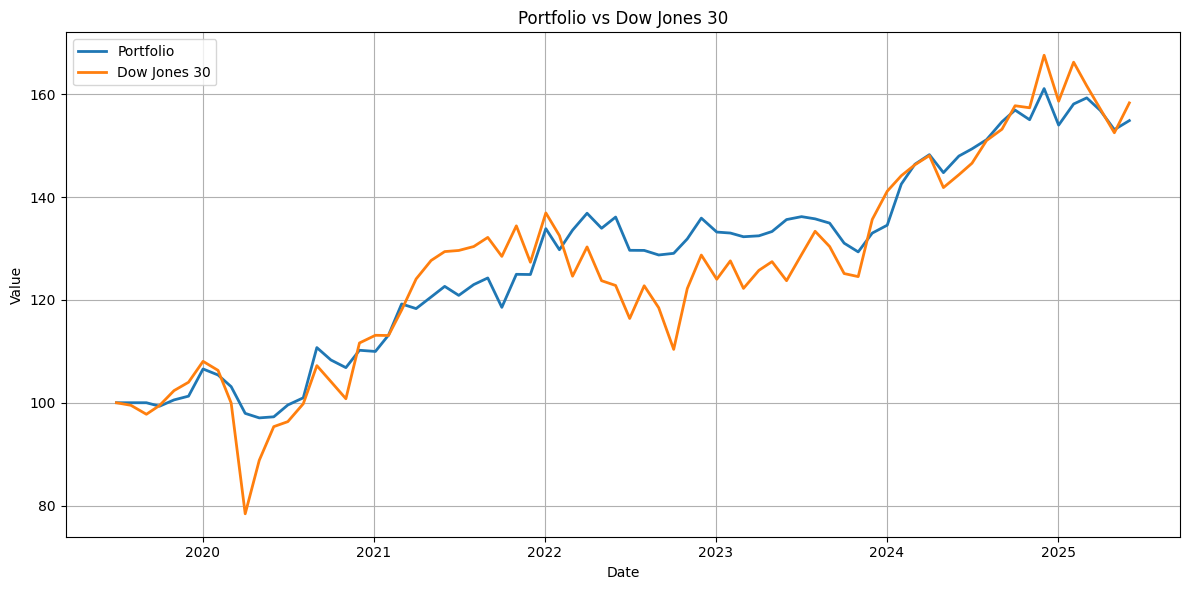


Generating Monthly Returns Heatmap...


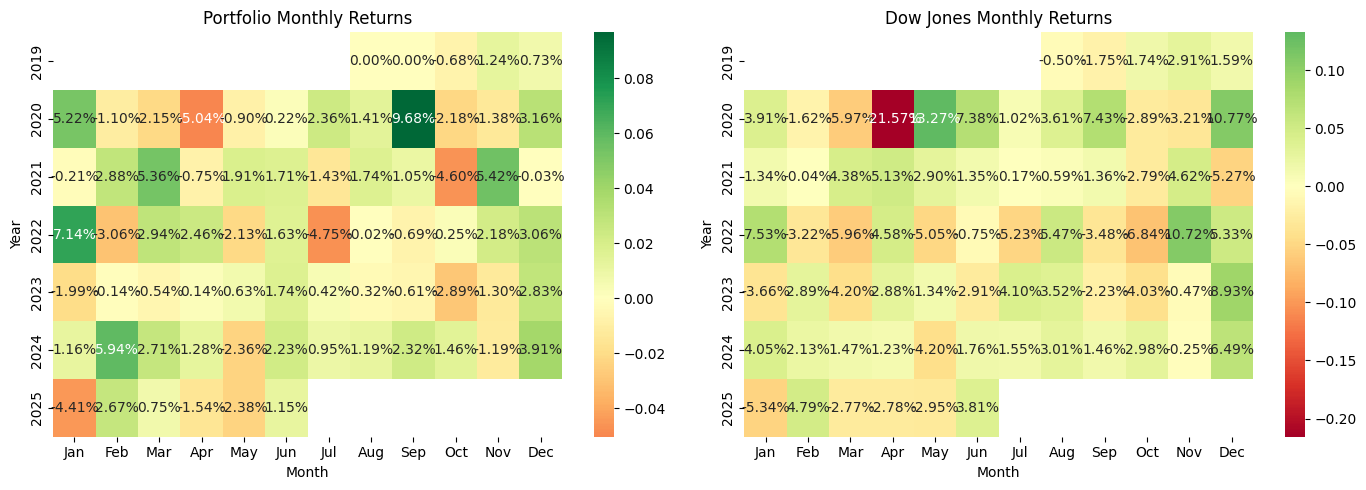

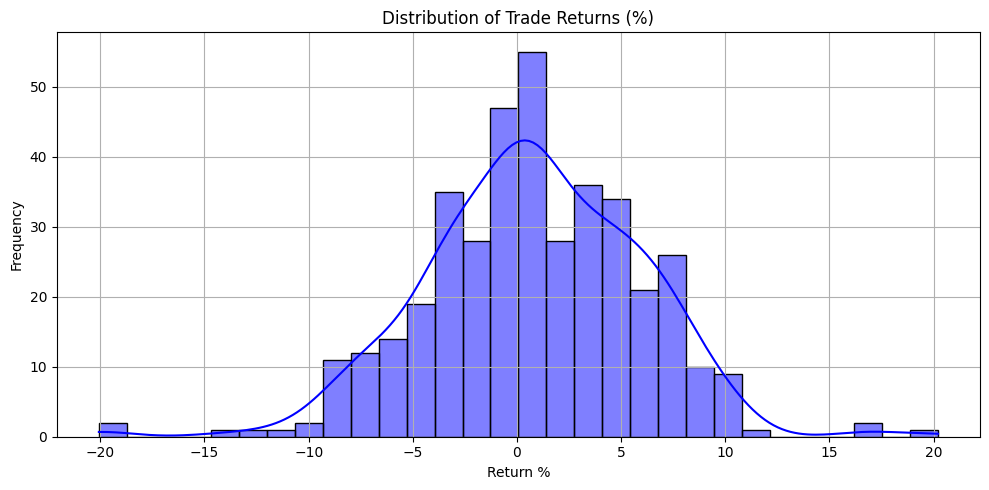

In [30]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

print("Momentum strategy with 52-week screen")

def momentum_52week_strategy(tickers, start_date, end_date):
    starting_cash = 100
    position_size = 20.0
    hold_period_days = 15
    transaction_cost_pct = 0.0003 # 3 basis points
    cash = starting_cash
    portfolio_value_daily = []
    open_positions = []
    daily_blocked_tickers = []
    all_trades = []

    print("Price data from Yahoo Finance...")
    data = yf.download(tickers, start=start_date, end=end_date, progress=False)
    close = data["Close"]
    high = data["High"]
    all_dates = close.index

    high_52w_prior = high.rolling(252, min_periods=50).max().shift(1)
    total_commission_paid = 0.0

    # ---------------- MAIN LOOP ---------------- #
    for i, current_date in enumerate(all_dates):

        # ---- Process open positions ----
        new_open_positions = []
        for pos in open_positions:
            buy_idx = all_dates.get_loc(pos["buy_date"])
            if i >= buy_idx + hold_period_days:
                sell_price = close.loc[current_date, pos["ticker"]]
                exit_amount = pos["shares"] * sell_price
                ret_pct = (sell_price - pos["buy_price"]) / pos["buy_price"] * 100

                sell_commission = exit_amount * transaction_cost_pct
                total_commission_paid += sell_commission
                cash += exit_amount - sell_commission

                all_trades.append({
                    "ticker": pos["ticker"],
                    "buy_date": pos["buy_date"].strftime('%Y-%m-%d'),
                    "buy_price": round(pos["buy_price"], 4),
                    "buy_amount": round(position_size, 2),
                    "exit_date": current_date.strftime('%Y-%m-%d'),
                    "exit_price": round(sell_price, 4),
                    "exit_amount": round(exit_amount, 2),
                    "return_pct": round(ret_pct, 2),
                    "commission": round(sell_commission + pos["buy_commission"], 6)
                })
            else:
                new_open_positions.append(pos)

        open_positions = new_open_positions

        # ---- Attempt new trades ----
        unable_to_fund = []

        for ticker in tickers:
            if ticker in [pos["ticker"] for pos in open_positions]:
                continue
            if ticker not in high.columns or ticker not in close.columns:
                continue
            if pd.isna(high.loc[current_date, ticker]):
                continue

            today_high = high.loc[current_date, ticker]
            today_close = close.loc[current_date, ticker]
            prior_52w_high = high_52w_prior.loc[current_date, ticker]

            if pd.isna(prior_52w_high):
                continue

            if today_high > prior_52w_high:
                if cash >= position_size:
                    shares = position_size / today_close
                    buy_commission = position_size * transaction_cost_pct

                    total_commission_paid += buy_commission
                    cash -= (position_size + buy_commission)

                    open_positions.append({
                        "ticker": ticker,
                        "buy_date": current_date,
                        "buy_price": today_close,
                        "shares": shares,
                        "buy_commission": buy_commission
                    })
                else:
                    unable_to_fund.append(ticker)

        daily_blocked_tickers.append({
            "date": current_date,
            "tickers unable to fund": unable_to_fund
        })

        # ---- Track portfolio value ----
        holdings_value = sum(pos["shares"] * close.loc[current_date, pos["ticker"]] for pos in open_positions)
        total_value = cash + holdings_value
        total_value_no_commission = total_value + total_commission_paid

        portfolio_value_daily.append({
            "date": current_date,
            "cash": round(cash, 2),
            "invested": round(holdings_value, 2),
            "total_value": round(total_value, 2),
            "total_value_no_commission": round(total_value_no_commission, 2),
            "holdings": [pos["ticker"] for pos in open_positions]
        })

    # ---------- END MAIN LOOP ---------- #

    pv = pd.DataFrame(portfolio_value_daily)
    pv_first_of_month = pv.copy()
    pv_first_of_month['month'] = pv_first_of_month['date'].dt.to_period('M')
    pv_first_of_month = pv_first_of_month.drop_duplicates(subset='month', keep='first')

    # ---- Holdings table ----
    holdings_table = pv_first_of_month[['date', 'holdings']].copy()
    holdings_table.rename(columns={'holdings': 'tickers_in_portfolio'}, inplace=True)
    holdings_table['num_stocks_held'] = holdings_table['tickers_in_portfolio'].apply(len)

    # ---- "Unable to fund" table ----
    blocked_df = pd.DataFrame(daily_blocked_tickers)
    blocked_df['month'] = blocked_df['date'].dt.to_period('M')
    blocked_first_of_month = blocked_df.drop_duplicates(subset='month', keep='first')

    monthly_info = pd.merge(
        holdings_table,
        blocked_first_of_month[['date', 'tickers unable to fund']],
        on='date',
        how='left'
    )
    monthly_info['tickers unable to fund'] = monthly_info['tickers unable to fund'].apply(lambda x: x if isinstance(x, list) else [])

    # ---- Benchmark (DJI) ----
    dji_data = yf.download("^DJI", start=start_date, end=end_date, progress=False)
    dji_close = dji_data["Close"]
    dji_on_pv_dates = dji_close.reindex(pv_first_of_month['date'], method='ffill')
    dji_start = dji_on_pv_dates.iloc[0]
    dji_scaled = 100 * (dji_on_pv_dates / dji_start)
    pv_first_of_month['dji_value_from_100'] = dji_scaled.values

    # ---- Drawdowns ----
    pv_first_of_month['portfolio_max_to_date'] = pv_first_of_month['total_value'].cummax()
    pv_first_of_month['dji_max_to_date'] = pv_first_of_month['dji_value_from_100'].cummax()

    pv_first_of_month['portfolio_drawdown_pct'] = (
        100 * (pv_first_of_month['total_value'] - pv_first_of_month['portfolio_max_to_date']) /
        pv_first_of_month['portfolio_max_to_date']
    ).round(2)

    pv_first_of_month['dji_drawdown_pct'] = (
        100 * (pv_first_of_month['dji_value_from_100'] - pv_first_of_month['dji_max_to_date']) /
        pv_first_of_month['dji_max_to_date']
    ).round(2)

    # ---- Trades ----
    trades_df = pd.DataFrame(all_trades)
    trades_first10 = trades_df.sort_values("buy_date").head(10)
    trades_last10 = trades_df.sort_values("buy_date").tail(10)

    # ---------------- OUTPUT TABLES ---------------- #
    print("\nPortfolio Value vs Dow Jones Index (DJI) on first trading day of each month:")
    print(pv_first_of_month[['date', 'cash', 'invested', 'total_value', 'total_value_no_commission',
                             'dji_value_from_100', 'portfolio_drawdown_pct', 'dji_drawdown_pct']].to_string(index=False))

    print("\nTotal commission paid over period:", round(total_commission_paid, 2))

    print("\nComparison of Dow Jones 30 and portfolio largest drawdowns:")
    dji_drawdowns = pv_first_of_month[['month', 'dji_drawdown_pct']].sort_values(by='dji_drawdown_pct').head(3)
    portfolio_drawdowns = pv_first_of_month[['month', 'portfolio_drawdown_pct']].sort_values(by='portfolio_drawdown_pct').head(3)
    portfolio_max_dd = pv_first_of_month['portfolio_drawdown_pct'].min()

    print("\nTop 3 largest drawdowns for Dow Jones 30:")
    print(dji_drawdowns.to_string(index=False))

    print("\nPortfolio largest drawdown over entire period:", portfolio_max_dd)
    print("\nTop 3 months with largest portfolio drawdowns:")
    print(portfolio_drawdowns.to_string(index=False))

    print("\nFirst 10 trades:")
    print(trades_first10.to_string(index=False))

    print("\nLast 10 trades:")
    print(trades_last10.to_string(index=False))

    print("\nPortfolio holdings and tickers unable to fund (date is first trading day of each month):")
    print(monthly_info.to_string(index=False))

    # ---------------- VISUALIZATION 1 ---------------- #
    # ---- LINE GRAPH: PORTFOLIO vs DOW JONES ----
    plt.figure(figsize=(12, 6))
    plt.plot(pv_first_of_month['date'], pv_first_of_month['total_value'], label='Portfolio', linewidth=2)
    plt.plot(pv_first_of_month['date'], pv_first_of_month['dji_value_from_100'], label='Dow Jones 30', linewidth=2)
    plt.title("Portfolio vs Dow Jones 30")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---------------- VISUALIZATION 2 ---------------- #
    # ---- MONTHLY RETURNS HEATMAP ----
    print("\nGenerating Monthly Returns Heatmap...")
    df_monthly = pv_first_of_month[['date', 'total_value', 'dji_value_from_100']].copy()
    df_monthly['return_portfolio'] = df_monthly['total_value'].pct_change()
    df_monthly['return_dji'] = df_monthly['dji_value_from_100'].pct_change()
    df_monthly['Year'] = df_monthly['date'].dt.year
    df_monthly['Month'] = df_monthly['date'].dt.month  # numeric month for sorting

    # Pivot and sort months correctly
    heatmap_df = df_monthly.pivot(index='Year', columns='Month', values='return_portfolio').sort_index(axis=1)
    heatmap_df_dji = df_monthly.pivot(index='Year', columns='Month', values='return_dji').sort_index(axis=1)

    month_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(heatmap_df, annot=True, fmt=".2%", cmap="RdYlGn", center=0, xticklabels=month_labels)
    plt.title("Portfolio Monthly Returns")

    plt.subplot(1, 2, 2)
    sns.heatmap(heatmap_df_dji, annot=True, fmt=".2%", cmap="RdYlGn", center=0, xticklabels=month_labels)
    plt.title("Dow Jones Monthly Returns")
    plt.tight_layout()
    plt.show()

    # ---------------- VISUALIZATION 3 ---------------- #
    # ---- DISTRIBUTION OF TRADE RETURNS ----
    if not trades_df.empty:
        plt.figure(figsize=(10, 5))
        sns.histplot(trades_df['return_pct'], bins=30, kde=True, color='blue')
        plt.title("Distribution of Trade Returns (%)")
        plt.xlabel("Return %")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("No trades available for histogram.")


    return trades_df, pv, open_positions, monthly_info, pv_first_of_month


# ---------------- RUN THE MODEL ---------------- #

tickers = [
    "AAPL","AMGN","AXP","BA","CAT","CRM","CSCO","CVX","DIS","DOW","GS","HD","HON","IBM",
    "INTC","JNJ","JPM","KO","MCD","MMM","MRK","MSFT","NKE","PFE","PG","RTX","TRV","UNH",
    "V","VZ","WMT"
]

trades, pv, open_positions, monthly_info, pv_first_of_month = momentum_52week_strategy(
    tickers,
    "2019-06-30",
    "2025-06-30"
)
